In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset

In [3]:
df_dev = pd.read_csv("dataset\subtaskA_clean_dev_cased.csv")
df_dev.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
df_dev.shape

(1840, 2)

In [5]:
X_dev = list(df_dev.comment_text) # lista di stringhe

In [6]:
y_dev = list(df_dev.conspiratorial)

In [7]:
# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(X_dev))
num_validation_samples

552

In [8]:
X_train = X_dev[:-num_validation_samples]
len(X_train)

1288

In [9]:
X_val = X_dev[-num_validation_samples:]
len(X_val)

552

In [10]:
y_train = y_dev[:-num_validation_samples]
len(y_train)

1288

In [11]:
y_val = y_dev[-num_validation_samples:]
len(y_val)

552

# Data Preprocessing

In [34]:
max_lenght = 705 # n° massimo di token contenuti in un post del dev, scoperto tramite un preprocessing preliminare

In [12]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_lenght)
text_ds = Dataset.from_tensor_slices(X_train).batch(128)
text_ds

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [13]:
vectorizer.adapt(text_ds)

In [14]:
vectorizer.get_vocabulary()[:15]

['',
 '[UNK]',
 'di',
 'e',
 'che',
 'il',
 'la',
 'in',
 'non',
 'a',
 'per',
 'i',
 'è',
 'del',
 'un']

In [15]:
vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
len(vocabulary)

12379

In [16]:
word_index

{'': 0,
 '[UNK]': 1,
 'di': 2,
 'e': 3,
 'che': 4,
 'il': 5,
 'la': 6,
 'in': 7,
 'non': 8,
 'a': 9,
 'per': 10,
 'i': 11,
 'è': 12,
 'del': 13,
 'un': 14,
 'le': 15,
 'una': 16,
 'ha': 17,
 'sono': 18,
 'si': 19,
 'della': 20,
 'da': 21,
 'con': 22,
 'dei': 23,
 'al': 24,
 'come': 25,
 'più': 26,
 'ma': 27,
 'gli': 28,
 'questo': 29,
 'se': 30,
 'alla': 31,
 'hanno': 32,
 'nel': 33,
 'lo': 34,
 'delle': 35,
 'anche': 36,
 'tutti': 37,
 'sul': 38,
 'o': 39,
 'questa': 40,
 'stato': 41,
 'ci': 42,
 'loro': 43,
 'solo': 44,
 'persone': 45,
 'covid19': 46,
 'su': 47,
 'essere': 48,
 'anni': 49,
 'dopo': 50,
 'ai': 51,
 'ad': 52,
 'tra': 53,
 'ed': 54,
 'contro': 55,
 'vaccini': 56,
 'dal': 57,
 'vaccino': 58,
 'perché': 59,
 'governo': 60,
 'no': 61,
 'cosa': 62,
 'fatto': 63,
 'chi': 64,
 'nella': 65,
 'stati': 66,
 'sia': 67,
 'dalla': 68,
 'russia': 69,
 'degli': 70,
 'vaccinati': 71,
 'trump': 72,
 'questi': 73,
 'fare': 74,
 'alle': 75,
 'tutto': 76,
 'quando': 77,
 'ora': 78,
 'senz

## Tokenization and Word Normalization (questa parte probabilmente non serve)

In [11]:
from nltk.tokenize import TweetTokenizer # Twitter-specific tokenizer
tokenizer = TweetTokenizer()

In [12]:
import re

def get_digits(text):
    try:
      val = int(text) # converte la stringa in intero
    except:
      text = re.sub('\d', '@Dg', text) # sostituisce a ogni cifra in text la stringa '@Dd'
      return text
    if val >= 0 and val < 2100: # se è un numero tra 0 e 2100
      return str(val) # viene lasciato uguale
    else:
      return "DIGLEN_" + str(len(str(val))) # viene indicato il numero di cifre che compongono quel numero

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper(): # se la parola inizia con la lettera maiuscola
      word = word.capitalize() # solo la prima viene lasciata maiuscola
    else:
      word = word.lower() # tutta in minuscolo
    return word

In [13]:
X_train_tokenized = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        post_tokens.append(sentence_tokens)
    X_train_tokenized.append(post_tokens)

In [14]:
len(X_train_tokenized)

1840

In [16]:
X_train_tokenized_flatten = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        for word in sentence_tokens:
            post_tokens.append(word)
    X_train_tokenized_flatten.append(post_tokens)

## Manual Padding (questa parte probabilmente non serve)

In [18]:
max_length = float('-inf')
for post in X_train_tokenized:
    post_words = 0
    for sentence in post:
        post_words += len(sentence)
    if post_words > max_length:
        max_length = post_words

max_length

705

In [19]:
for post in X_train_tokenized_flatten:
    if len(post) < max_length:
        for i in range(max_length-len(post)):
            post.append('[UNK]')

In [20]:
X_train_tokenized_flatten = np.array(X_train_tokenized_flatten)

In [21]:
X_train_tokenized_flatten.shape

(1840, 705)

## Word Embeddings

In [17]:
embeddings_path = '..\..\itwac128.txt'

In [18]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [19]:
embeddings = load_word_embeddings(embeddings_path)

In [20]:
len(embeddings)

1247492

### Creazione di una matrice di embeddings

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the embedding for the word of index i in our vectorizer's vocabulary.

In [21]:
num_tokens = len(vocabulary) + 2
embedding_dim = 128
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10776 words (1603 misses)


In [22]:
embedding_matrix.shape

(12381, 128)

In [37]:
embedding_matrix.shape[0]

12381

# Codice di Attardi

In [35]:
RNN_HIDDEN_SIZE = 50

In [60]:
model = Sequential()
model.add(Embedding(
    embedding_matrix.shape[0],
    embedding_dim,
    input_length=max_lenght)) 
    #mask_zero=True)) # 0-padding should be masked out

In [61]:
model.add(Bidirectional(LSTM(RNN_HIDDEN_SIZE, return_sequences=True, dropout=0.1), merge_mode='concat'))

In [62]:
model.add(Dense(2, activation="softmax"))

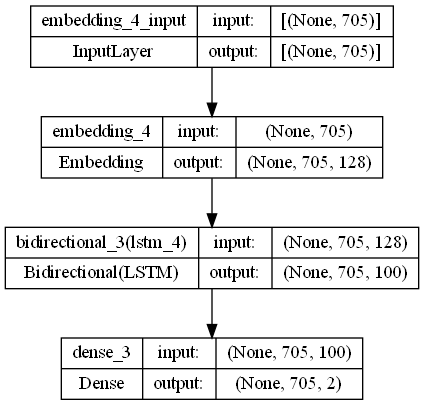

In [63]:
plot_model(model, show_shapes=True)

In [64]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', # Adam(0.001)
              metrics=['accuracy'])

In [65]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [66]:
history = model.fit(x_train, y_train, epochs=4, validation_data=(x_val, y_val))

Epoch 1/4


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\irene\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\irene\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\irene\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\irene\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\irene\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\irene\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\irene\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\irene\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\irene\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\irene\AppData\Local\Temp\ipykernel_19816\1780746766.py", line 1, in <module>
      history = model.fit(x_train, y_train, epochs=4, validation_data=(x_val, y_val))
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\irene\anaconda3\lib\site-packages\keras\backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [22560,2] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_37872]

# Model Building

In [67]:
from tensorflow.keras.initializers import Constant
from keras import Input, Model

In [68]:
num_tokens

12381

In [72]:
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_dim,
    input_length=max_lenght,
    mask_zero=True) # 0-padding should be masked out

In [73]:
int_sequences_input = Input(shape=(None,), dtype="int64")
int_sequences_input

<KerasTensor: shape=(None, None) dtype=int64 (created by layer 'input_3')>

In [74]:
embedded_sequences = embedding_layer(int_sequences_input)
embedded_sequences

<KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'embedding_6')>

In [75]:
#x = Bidirectional(LSTM(RNN_HIDDEN_SIZE, return_sequences=True, dropout=0.1)(embedded_sequences),
                  merge_mode='concat')

ValueError: Please initialize `Bidirectional` layer with a `tf.keras.layers.Layer` instance. Received: KerasTensor(type_spec=TensorSpec(shape=(None, None, 50), dtype=tf.float32, name=None), name='lstm_5/PartitionedCall:1', description="created by layer 'lstm_5'")

In [76]:
x = LSTM(RNN_HIDDEN_SIZE)(embedded_sequences)
preds = Dense(2, activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 128)         1584768   
                                                                 
 lstm_6 (LSTM)               (None, 50)                35800     
                                                                 
 dense_4 (Dense)             (None, 2)                 102       
                                                                 
Total params: 1,620,670
Trainable params: 1,620,670
Non-trainable params: 0
_________________________________________________________________


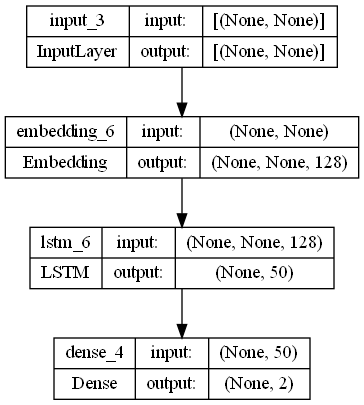

In [77]:
plot_model(model, show_shapes=True)

In [78]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

In [79]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_val, y_val))

Epoch 1/3
11/11 [==============================] - 34s 3s/step - loss: 0.6931 - accuracy: 0.4953 - val_loss: 0.6935 - val_accuracy: 0.4819
Epoch 2/3
11/11 [==============================] - 47s 5s/step - loss: 0.6928 - accuracy: 0.5039 - val_loss: 0.6936 - val_accuracy: 0.4909
Epoch 3/3
11/11 [==============================] - 84s 8s/step - loss: 0.6927 - accuracy: 0.5101 - val_loss: 0.6940 - val_accuracy: 0.4746


In [152]:
history = model.history

In [153]:
import matplotlib.pyplot as plt

In [154]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

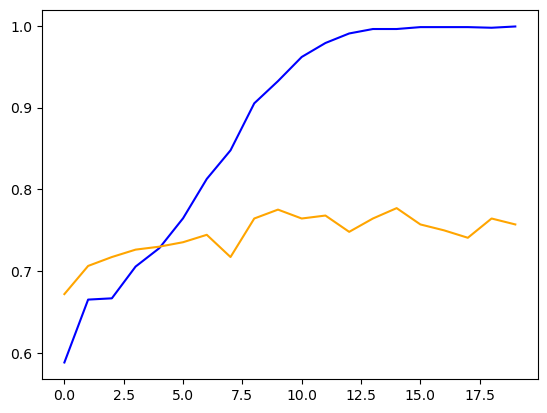

In [156]:
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='orange')
plt.show()

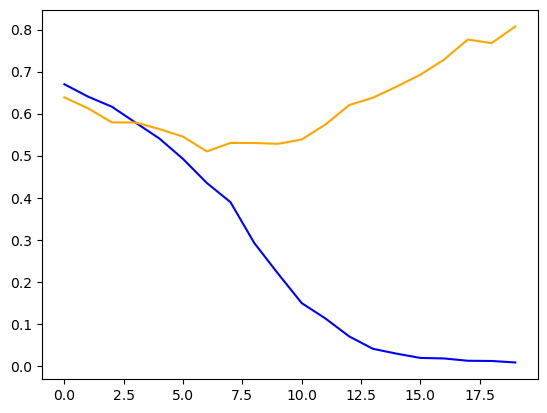

In [157]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')
plt.show()

https://keras.io/examples/nlp/pretrained_word_embeddings/